In [1]:
import torch
import numpy as np
from torch import optim, nn, utils, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import EMNIST
from torchvision import transforms

In [2]:
# Define CNN encoder
class Encoder(nn.Module):
    def __init__(self, data_channels, channels_A, channels_B, channels_C, channels_D, latent_dim):
        super(Encoder, self).__init__()
        # Layers
        self.conv_dataA =nn.Conv2d(data_channels, channels_A, kernel_size=5, stride=2)
        self.conv_AB    =nn.Conv2d(channels_A, channels_B, kernel_size=3, stride=1)
        self.conv_BC    =nn.Conv2d(channels_B, channels_C, kernel_size=5, stride = 1)
        self.conv_CD    =nn.Conv2d(channels_C, channels_D, kernel_size=3, stride = 1)
        self.fc_Dmean   =nn.Linear(channels_D * 16, latent_dim)
        self.fc_Dlog_var=nn.Linear(channels_D * 16, latent_dim)

    def forward(self, x):
        # Apply layers
        x = F.relu(self.conv_dataA(x))
        x = F.relu(self.conv_AB(x))
        x = F.relu(self.conv_BC(x))
        x = F.relu(self.conv_CD(x))
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_Dmean(x)
        log_var = self.fc_Dlog_var(x)
        return mu, log_var

In [3]:
# Define CNN decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, channels_D, channels_C, channels_B, channels_A, data_channels):
        super(Decoder, self).__init__()
        self.channels_D = channels_D
        # Layers
        self.fc_LatentD =nn.Linear(latent_dim, channels_D * 16)
        self.conv_tDC   =nn.ConvTranspose2d(channels_D, channels_C, kernel_size=3, stride=1)
        self.conv_tCB   =nn.ConvTranspose2d(channels_C, channels_B, kernel_size=5, stride=1)
        self.conv_tBA   =nn.ConvTranspose2d(channels_B, channels_A, kernel_size=3, stride=1)
        self.conv_tAdata=nn.ConvTranspose2d(channels_A, data_channels, kernel_size=5, stride=2, output_padding=1)

    def forward(self, z):
        # Apply layers
        z = self.fc_LatentD(z)
        z = z.view(-1, self.channels_D, 4, 4)
        z = F.relu(self.conv_tDC(z))
        z = F.relu(self.conv_tCB(z))
        z = F.relu(self.conv_tBA(z))
        recon = torch.sigmoid(self.conv_tAdata(z))
        return recon

In [4]:
# Define VAE
class VAE(nn.Module):
    def __init__(self, latent_dim, channels_A, channels_B, channels_C, channels_D, data_channels):
        super(VAE, self).__init__()
        self.encoder = Encoder(data_channels, channels_A, channels_B, channels_C, channels_D, latent_dim)
        self.decoder = Decoder(latent_dim, channels_D, channels_C, channels_B, channels_A, data_channels)

    def reparameterize(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        eps = torch.randn_like(sigma)
        return mu + (eps * sigma)

    def forward(self, x, do_reparam = True):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var) if do_reparam else mu
        return self.decoder(z), mu, log_var

In [5]:
# Define Evaluator
class Evaluator(nn.Module):
    def __init__(self, data_dim, hidden_dim1, hidden_dim2, value_dim):
        super(Evaluator, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(data_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.value = nn.Linear(hidden_dim2, value_dim)

    def forward(self, x):
        # Apply non-linear transformations
        x = torch.flatten(x, start_dim = 1)
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        evaluation = F.relu(self.value(h2))
        return evaluation

In [6]:
# Define sample displayer
def displayer(sampling, x_len, data_x, data_y, rgb = False):
    fig_x = min(sampling, x_len)
    fig, axes = plt.subplots(2, fig_x, figsize=(fig_x, 2))

    if rgb:
        for i in range(0, fig_x):
            pos = i % fig_x
            image = x[i].permute(1, 2, 0)
            axes[int(i/fig_x)*2][pos].imshow(image.cpu())
            axes[int(i/fig_x)*2][pos].axis('off')  # Turn off axis numbers

            image = recon_x[i].permute(1, 2, 0)
            axes[int(i/fig_x)*2+1][pos].imshow(image.detach().cpu())
            axes[int(i/fig_x)*2+1][pos].axis('off')  # Turn off axis numbers
        plt.show()
        plt.close()
    else:
        for i in range(0, fig_x):
            pos = i % fig_x
            image = x[i].view(data_x, data_y)
            axes[int(i/fig_x)*2][pos].imshow(image.cpu(), cmap='gray')
            axes[int(i/fig_x)*2][pos].axis('off')  # Turn off axis numbers

            image = recon_x[i].view(data_x, data_y)
            axes[int(i/fig_x)*2+1][pos].imshow(image.detach().cpu(), cmap='gray')
            axes[int(i/fig_x)*2+1][pos].axis('off')  # Turn off axis numbers
        plt.show()
        plt.close()

In [7]:
# Randomness control
torch.manual_seed(2022313045)
np.random.seed(2022313045)

# Metadata
dataset_folder = '../Datasets'
data_is_rgb = False
data_channels = 3 if data_is_rgb else 1
data_x = 28
data_y = 28
latent_dim = 70
channels_D = 80 * data_channels
channels_C = 40 * data_channels
channels_B = 20 * data_channels
channels_A = 10 * data_channels
data_dim = data_x*data_y*data_channels
hidden_dim1 = 400
hidden_dim2 = 200
value_dim = 100

# Set computing device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

    # Datasets
data_train = EMNIST('../../../Datasets', split='byclass', train=True, transform=transform)
data_test = EMNIST('../../../Datasets', split='byclass', train=False, transform=transform)

# Neural Networks
model = VAE(latent_dim, channels_A, channels_B, channels_C, channels_D, data_channels).to(device)
evaluator = Evaluator(data_dim, hidden_dim1, hidden_dim2, value_dim).to(device)

In [8]:
model = VAE(latent_dim, channels_A, channels_B, channels_C, channels_D, data_channels).to(device)
evaluator = Evaluator(data_dim, hidden_dim1, hidden_dim2, value_dim).to(device)
optimizer_VAE = optim.Adam(model.parameters(), lr=0.0005)
optimizer_Eval = optim.Adam(evaluator.parameters(), lr=0.00005)
optimizer_EVAE = optim.Adam(list(model.parameters()) + list(evaluator.parameters()), lr=0.0001)

checkpoint = torch.load('emnist_model_trainable_1.pt')

model.load_state_dict(checkpoint['model_state_dict'])
evaluator.load_state_dict(checkpoint['evaluator_state_dict'])
optimizer_VAE.load_state_dict(checkpoint['optimizer_VAE_state_dict'])
optimizer_Eval.load_state_dict(checkpoint['optimizer_Eval_state_dict'])
optimizer_EVAE.load_state_dict(checkpoint['optimizer_EVAE_state_dict'])

model.eval()
evaluator.eval()

Evaluator(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (value): Linear(in_features=200, out_features=100, bias=True)
)

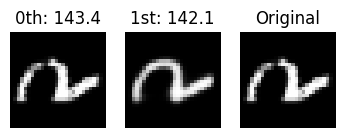

1, 185.13528442382812, 185.13528442382812


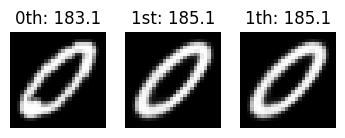

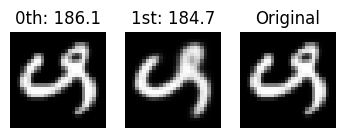

3, 200.08648681640625, 199.34774780273438


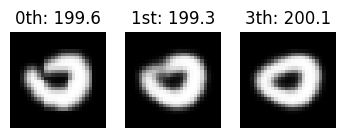

1, 171.4715576171875, 171.4715576171875


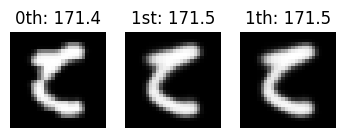

1, 174.34979248046875, 174.34979248046875


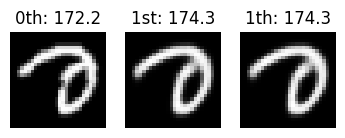

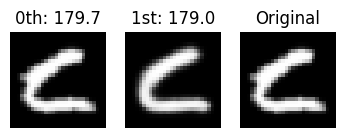

1, 167.90158081054688, 167.90158081054688


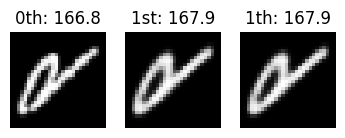

3, 159.05630493164062, 157.63314819335938


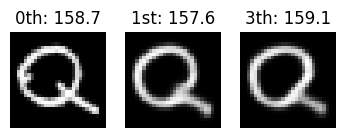

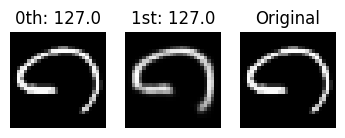

1, 157.66134643554688, 157.66134643554688


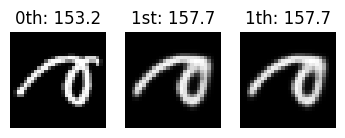

1, 166.6989288330078, 166.6989288330078


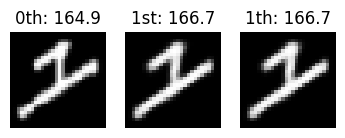

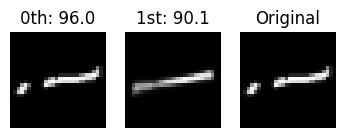

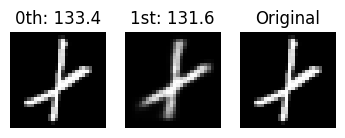

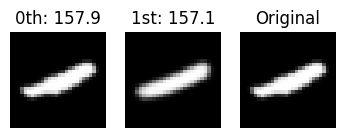

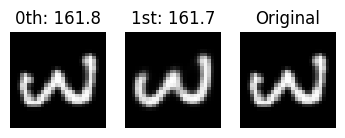

1, 201.8843994140625, 201.8843994140625


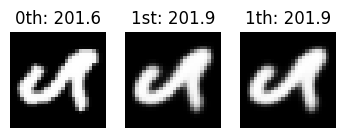

1, 193.7615509033203, 193.7615509033203


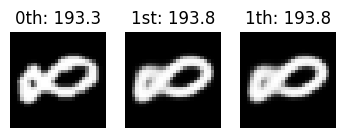

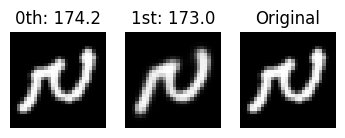

1, 166.58981323242188, 166.58981323242188


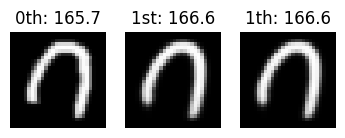

1, 161.99057006835938, 161.99057006835938


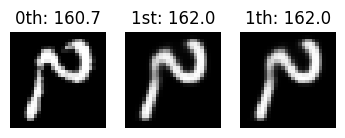

1, 158.13050842285156, 158.13050842285156


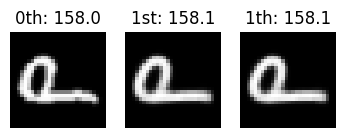

1, 163.6969757080078, 163.6969757080078


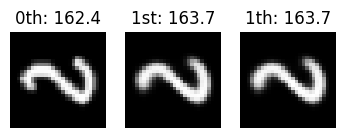

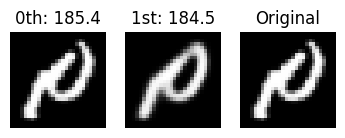

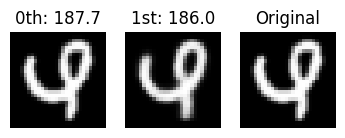

3, 161.43679809570312, 159.06097412109375


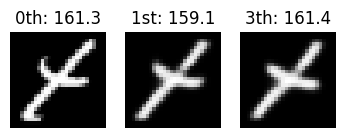

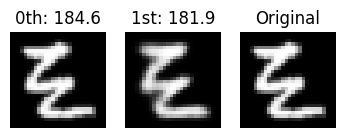

1, 165.46832275390625, 165.46832275390625


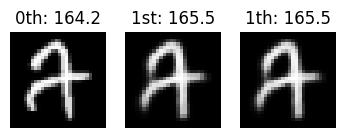

1, 166.50042724609375, 166.50042724609375


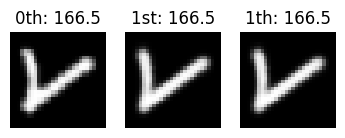

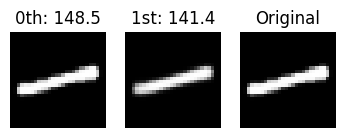

1, 204.62974548339844, 204.62974548339844


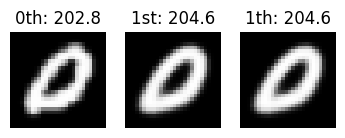

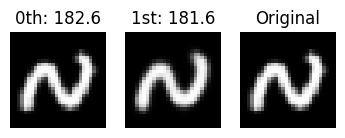

1, 158.73953247070312, 158.73953247070312


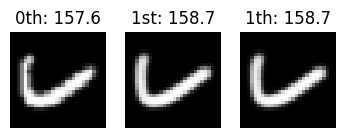

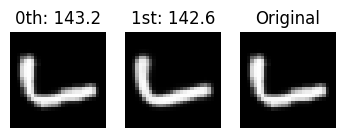

1, 162.55581665039062, 162.55581665039062


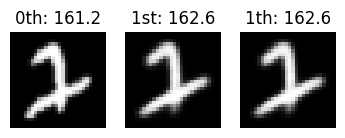

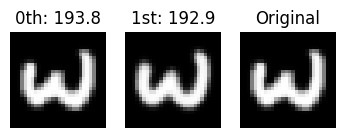

1, 197.28778076171875, 197.28778076171875


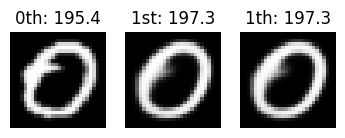

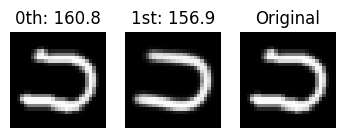

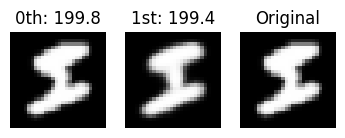

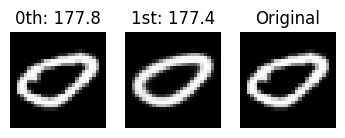

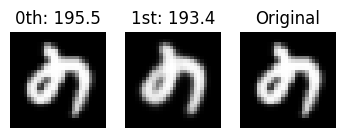

1, 147.57113647460938, 147.57113647460938


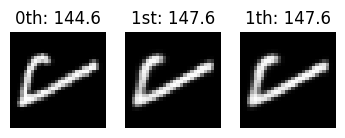

2, 192.66444396972656, 191.62359619140625


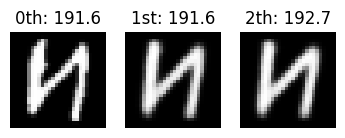

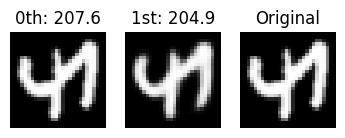

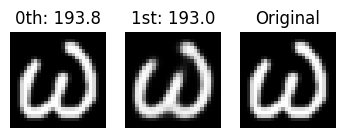

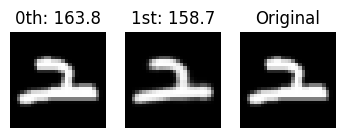

1, 163.7867431640625, 163.7867431640625


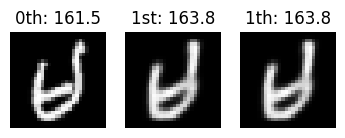

1, 188.9510955810547, 188.9510955810547


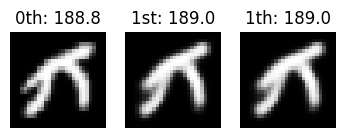

1, 175.998046875, 175.998046875


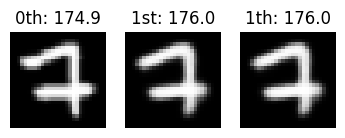

1, 178.96163940429688, 178.96163940429688


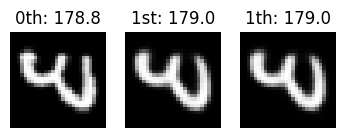

2, 164.36553955078125, 164.056640625


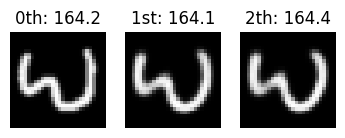

1, 161.15512084960938, 161.15512084960938


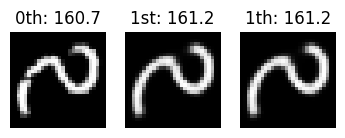

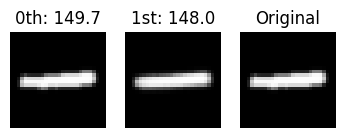

1, 156.0602264404297, 156.0602264404297


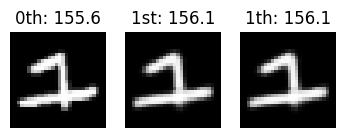

1, 152.67758178710938, 152.67758178710938


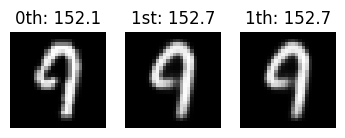

1, 165.23211669921875, 165.23211669921875


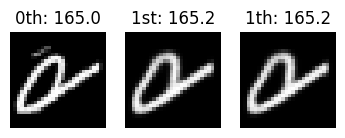

1, 180.3099365234375, 180.3099365234375


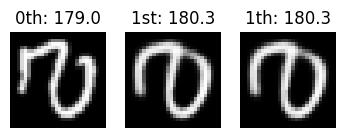

1, 199.65602111816406, 199.65602111816406


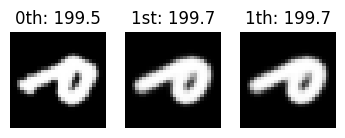

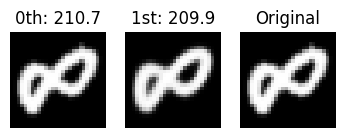

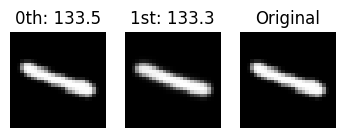

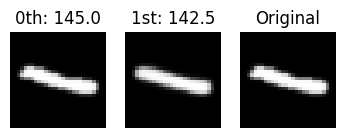

1, 148.529052734375, 148.529052734375


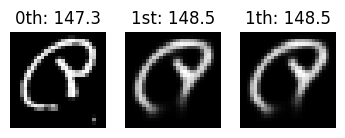

1, 178.3488006591797, 178.3488006591797


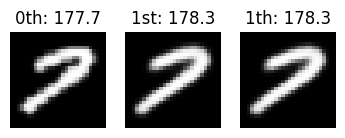

2, 166.84408569335938, 165.1463165283203


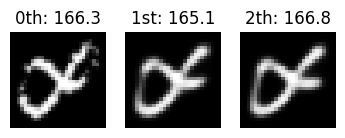

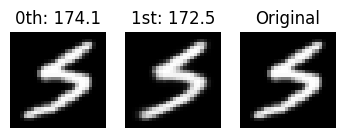

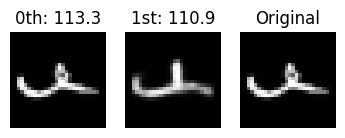

1, 151.4346923828125, 151.4346923828125


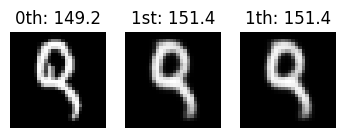

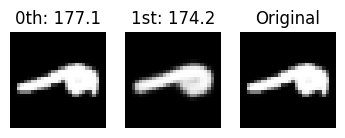

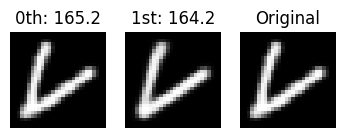

1, 156.228271484375, 156.228271484375


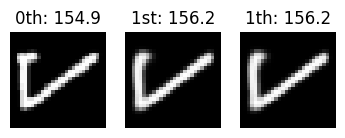

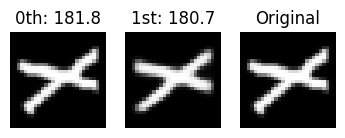

1, 150.98641967773438, 150.98641967773438


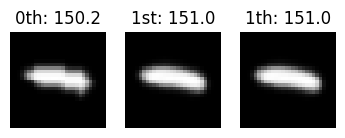

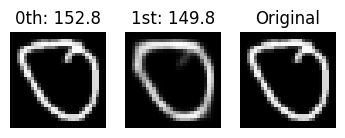

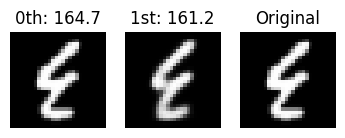

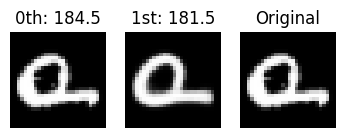

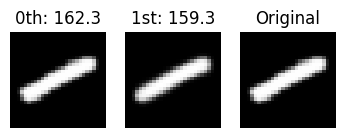

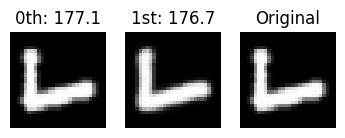

1, 160.66705322265625, 160.66705322265625


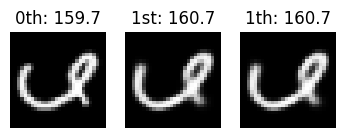

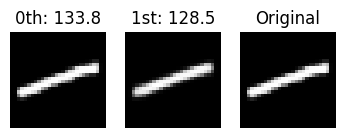

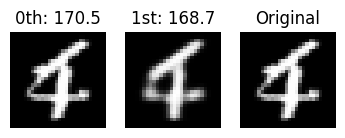

1, 195.13681030273438, 195.13681030273438


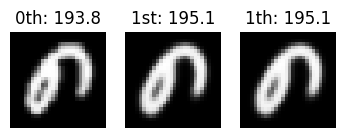

1, 141.18118286132812, 141.18118286132812


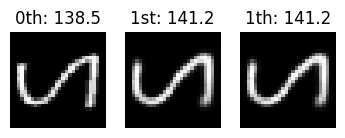

1, 151.12738037109375, 151.12738037109375


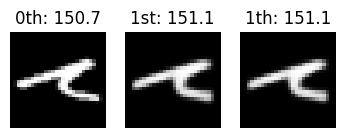

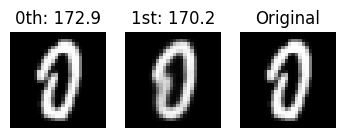

1, 128.10113525390625, 128.10113525390625


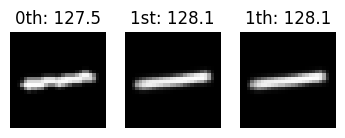

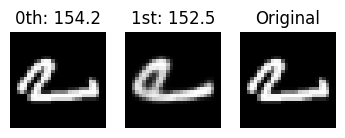

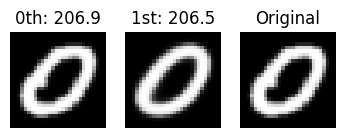

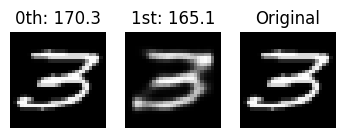

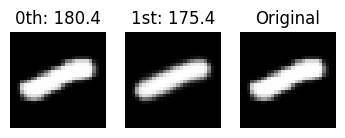

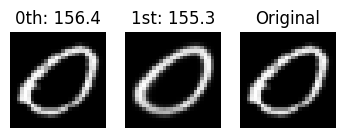

1, 176.11741638183594, 176.11741638183594


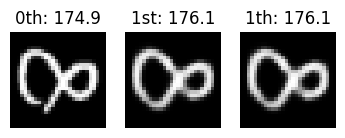

1, 164.21884155273438, 164.21884155273438


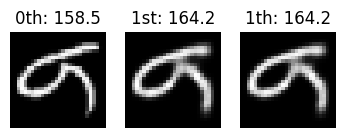

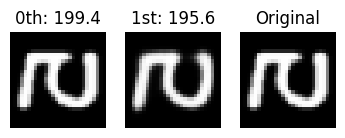

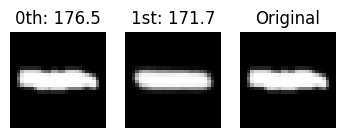

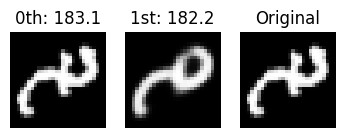

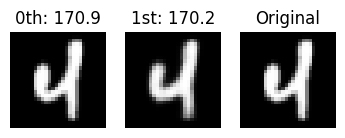

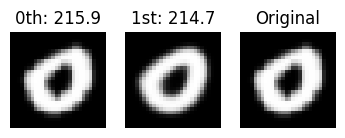

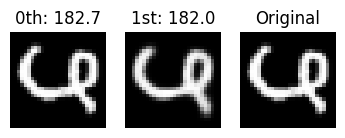

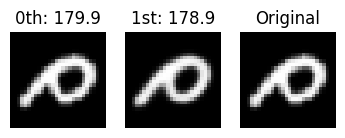

1, 188.3863067626953, 188.3863067626953


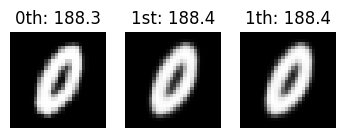

1, 154.672119140625, 154.672119140625


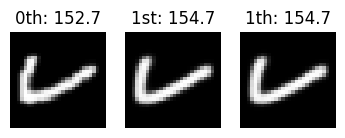

1, 222.6194610595703, 222.6194610595703


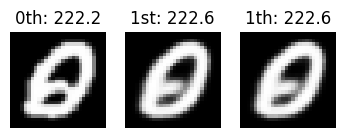

1, 153.59945678710938, 153.59945678710938


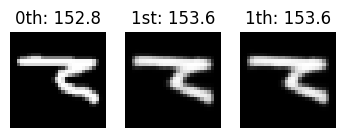

1, 148.19972229003906, 148.19972229003906


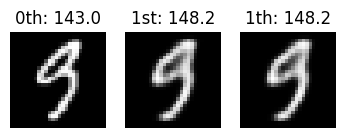

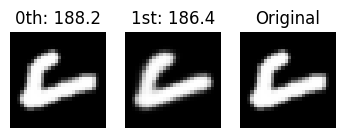

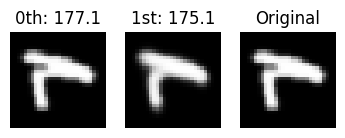

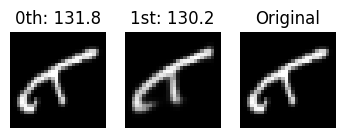

1, 165.8763885498047, 165.8763885498047


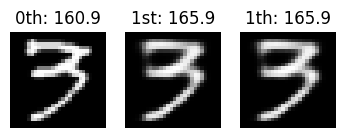

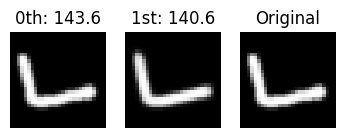

1, 132.03887939453125, 132.03887939453125


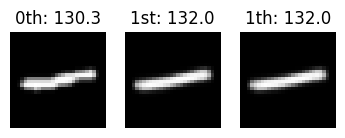

1, 153.8102569580078, 153.8102569580078


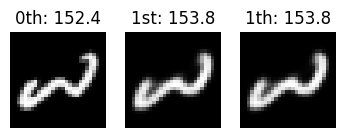

1, 146.50418090820312, 146.50418090820312


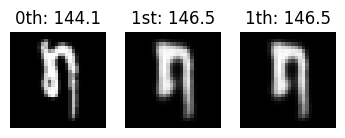

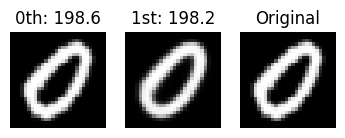

1, 153.33047485351562, 153.33047485351562


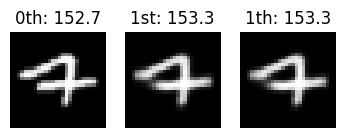

1, 130.97207641601562, 130.97207641601562


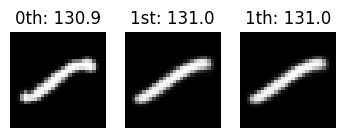

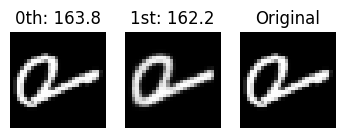

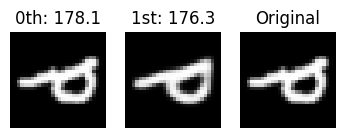

1, 169.37835693359375, 169.37835693359375


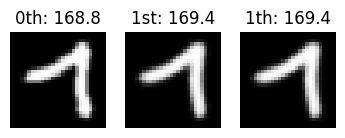

1, 182.7071533203125, 182.7071533203125


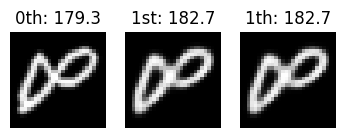

1, 166.46673583984375, 166.46673583984375


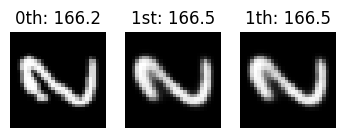

1, 189.53115844726562, 189.53115844726562


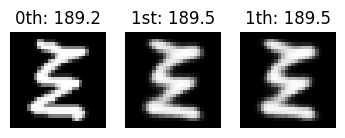

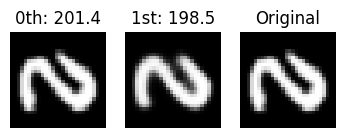

1, 209.153076171875, 209.153076171875


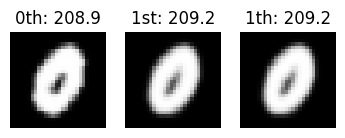

1, 128.053955078125, 128.053955078125


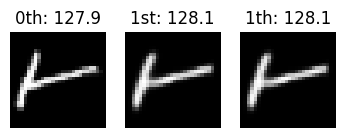

1, 194.3519287109375, 194.3519287109375


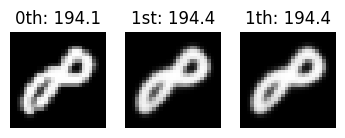

1, 175.85513305664062, 175.85513305664062


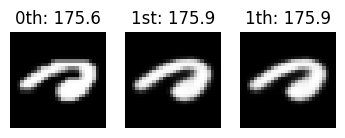

1, 164.11273193359375, 164.11273193359375


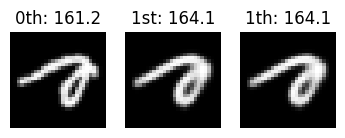

1, 198.59580993652344, 198.59580993652344


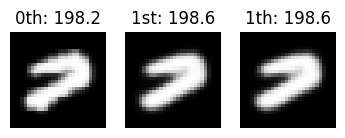

1, 181.79296875, 181.79296875


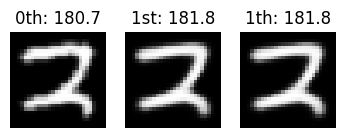

1, 163.64987182617188, 163.64987182617188


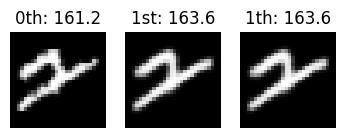

1, 158.4656524658203, 158.4656524658203


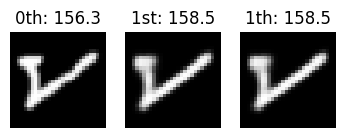

1, 114.11229705810547, 114.11229705810547


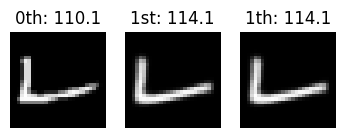

1, 146.5968780517578, 146.5968780517578


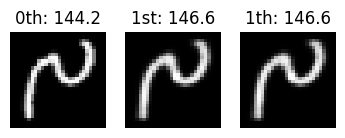

1, 193.02740478515625, 193.02740478515625


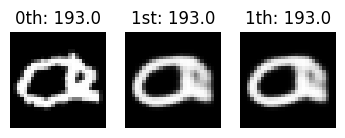

2, 145.03323364257812, 144.44818115234375


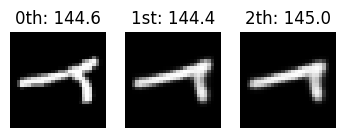

1, 143.62997436523438, 143.62997436523438


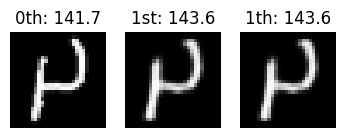

1, 178.57577514648438, 178.57577514648438


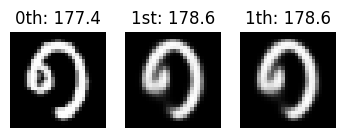

1, 173.76092529296875, 173.76092529296875


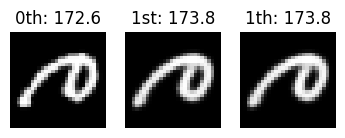

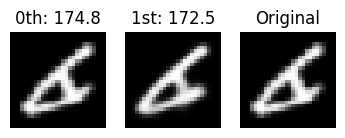

1, 160.63494873046875, 160.63494873046875


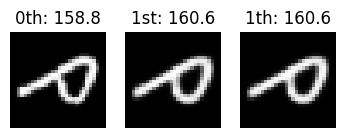

1, 149.27932739257812, 149.27932739257812


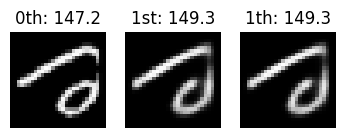

4, 214.76766967773438, 214.28651428222656


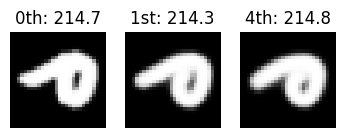

1, 139.49618530273438, 139.49618530273438


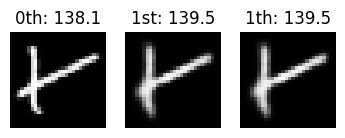

1, 180.66563415527344, 180.66563415527344


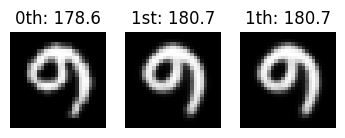

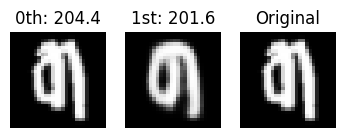

1, 142.96853637695312, 142.96853637695312


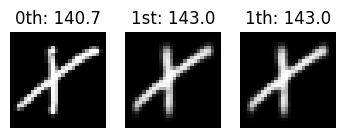

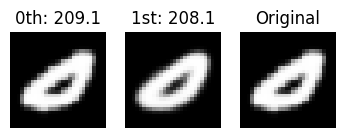

1, 181.96929931640625, 181.96929931640625


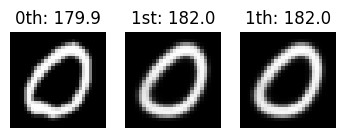

1, 163.39126586914062, 163.39126586914062


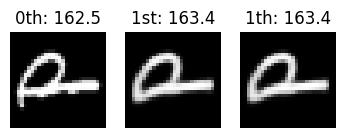

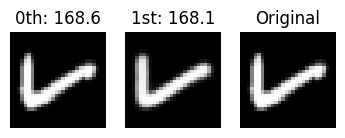

1, 147.93399047851562, 147.93399047851562


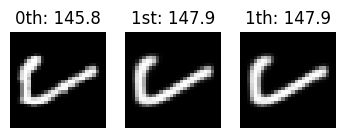

1, 172.76612854003906, 172.76612854003906


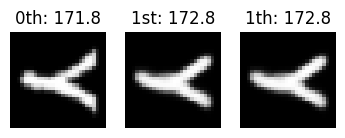

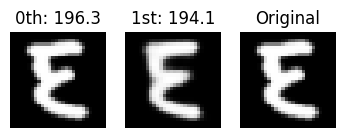

1, 184.39703369140625, 184.39703369140625


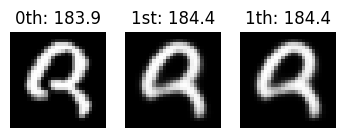

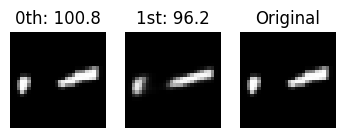

1, 191.60598754882812, 191.60598754882812


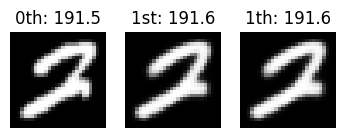

1, 207.07313537597656, 207.07313537597656


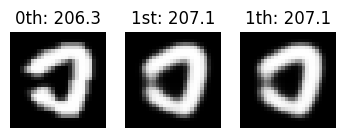

1, 130.95697021484375, 130.95697021484375


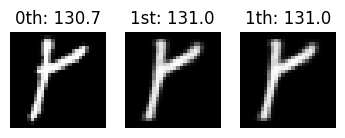

1, 199.20254516601562, 199.20254516601562


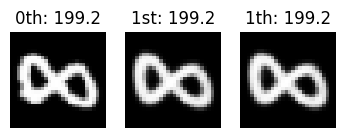

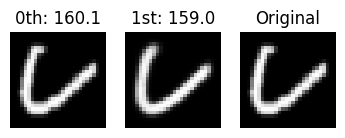

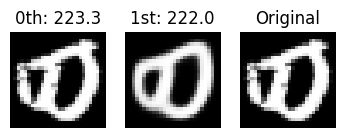

1, 194.18215942382812, 194.18215942382812


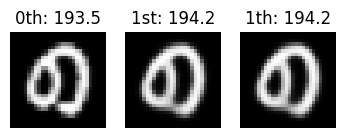

1, 185.91006469726562, 185.91006469726562


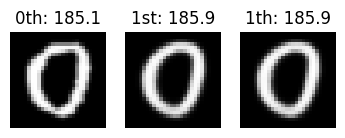

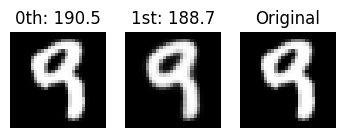

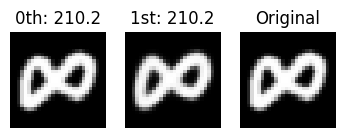

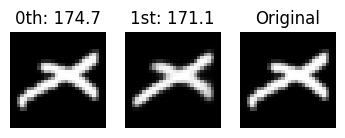

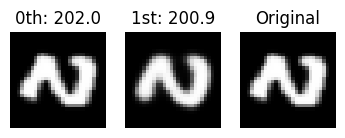

1, 150.26455688476562, 150.26455688476562


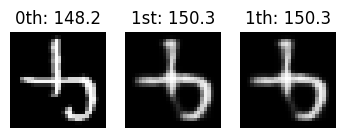

4, 183.472900390625, 182.63052368164062


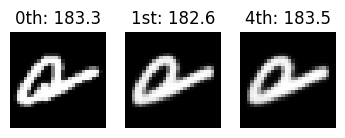

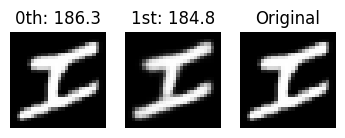

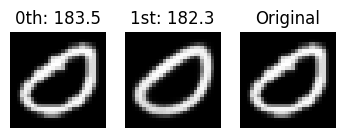

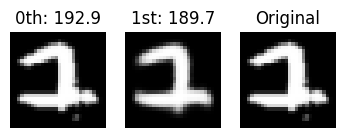

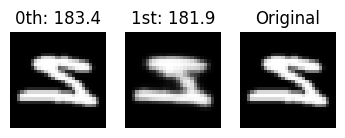

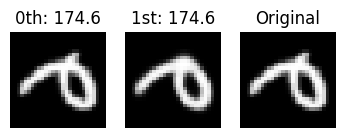

1, 194.722900390625, 194.722900390625


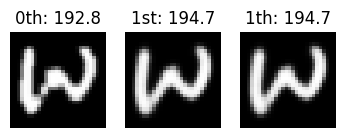

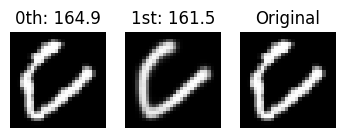

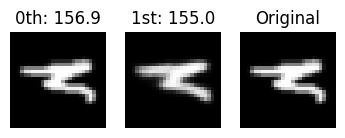

1, 129.43746948242188, 129.43746948242188


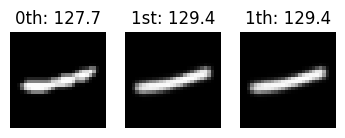

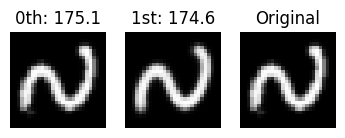

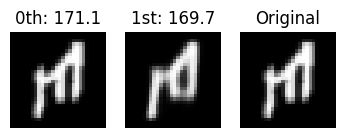

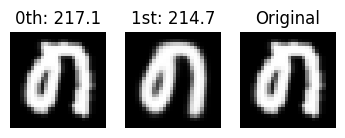

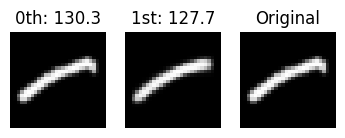

1, 180.10446166992188, 180.10446166992188


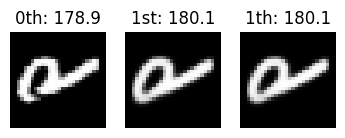

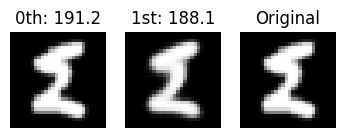

1, 174.2283935546875, 174.2283935546875


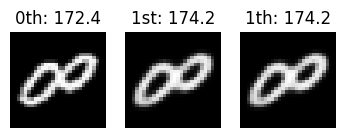

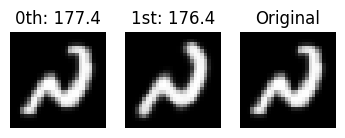

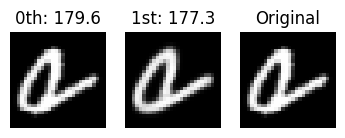

1, 157.83160400390625, 157.83160400390625


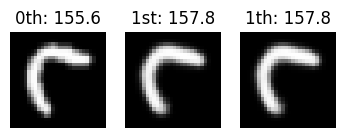

1, 194.32864379882812, 194.32864379882812


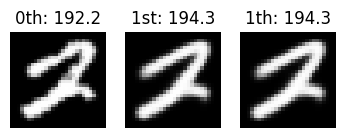

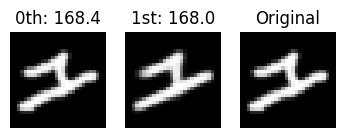

1, 126.18862915039062, 126.18862915039062


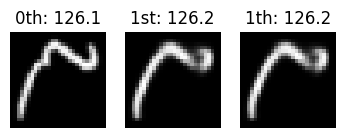

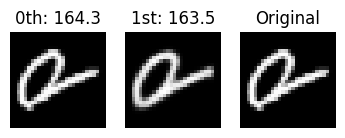

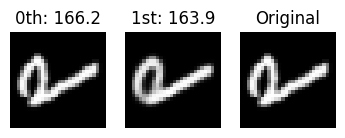

1, 147.43765258789062, 147.43765258789062


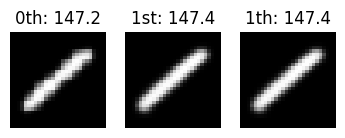

1, 193.99102783203125, 193.99102783203125


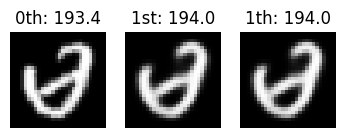

1, 146.9891815185547, 146.9891815185547


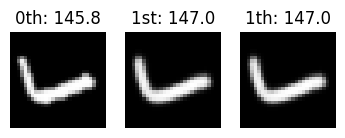

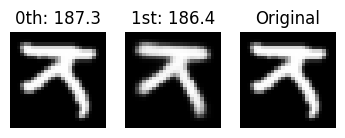

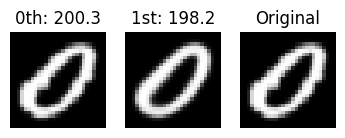

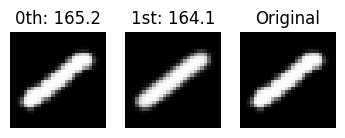

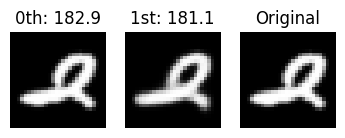

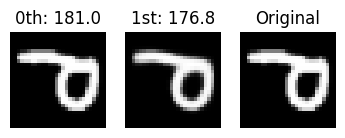

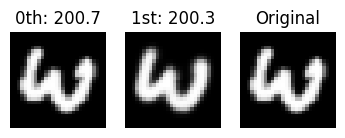

1, 196.9421844482422, 196.9421844482422


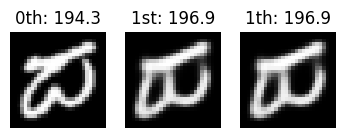

1, 151.92999267578125, 151.92999267578125


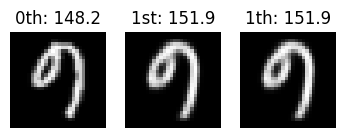

1, 161.91561889648438, 161.91561889648438


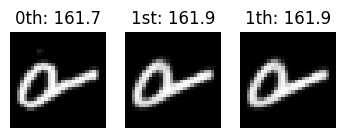

1, 170.20111083984375, 170.20111083984375


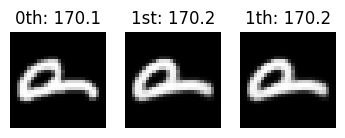

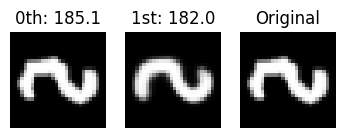

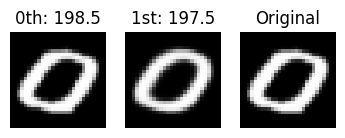

2, 175.13595581054688, 173.93252563476562


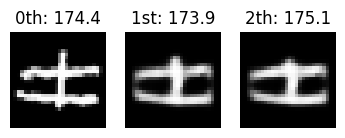

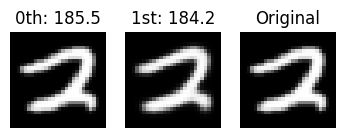

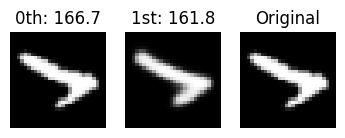

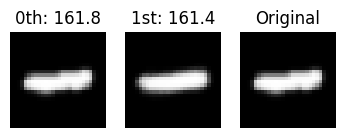

1, 168.59555053710938, 168.59555053710938


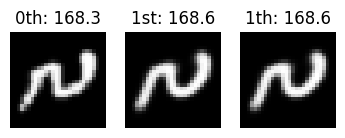

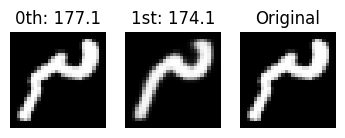

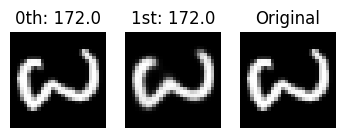

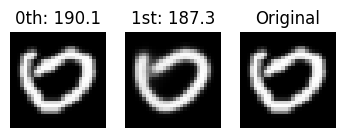

4, 172.12200927734375, 170.96923828125


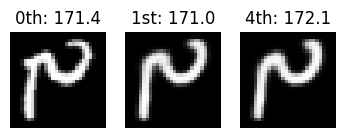

1, 188.99241638183594, 188.99241638183594


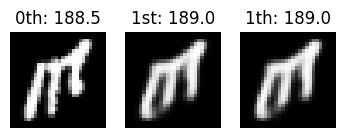

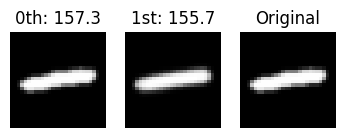

1, 186.63345336914062, 186.63345336914062


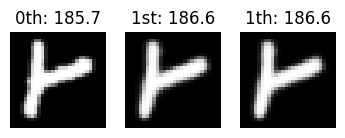

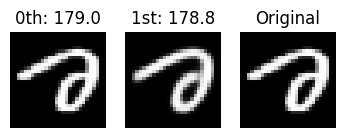

1, 192.47979736328125, 192.47979736328125


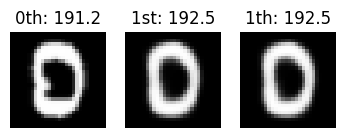

1, 142.21429443359375, 142.21429443359375


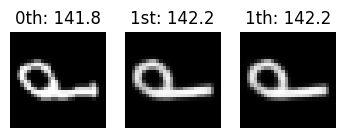

1, 193.50119018554688, 193.50119018554688


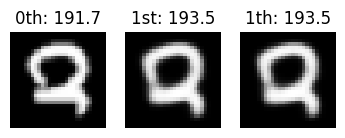

1, 142.57508850097656, 142.57508850097656


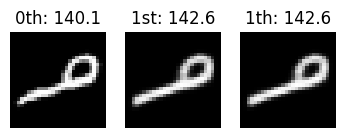

1, 167.22264099121094, 167.22264099121094


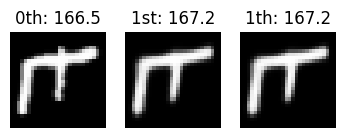

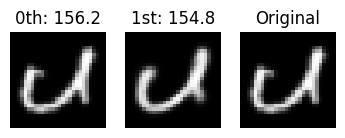

1, 137.2586669921875, 137.2586669921875


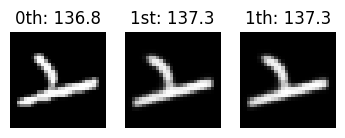

1, 168.6470947265625, 168.6470947265625


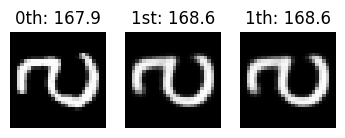

1, 110.89482116699219, 110.89482116699219


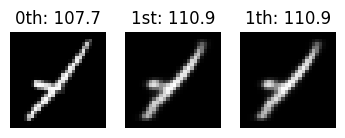

1, 153.39492797851562, 153.39492797851562


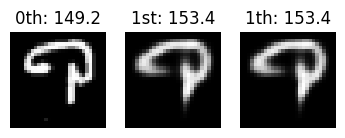

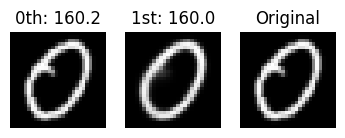

1, 163.37973022460938, 163.37973022460938


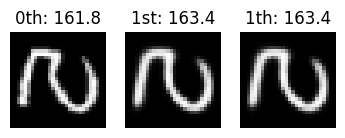

1, 193.25070190429688, 193.25070190429688


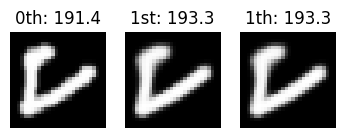

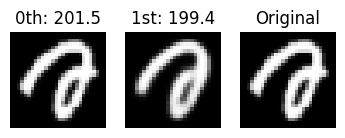

1, 179.1957244873047, 179.1957244873047


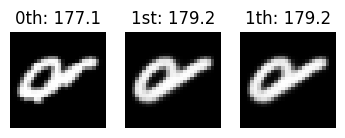

1, 162.20516967773438, 162.20516967773438


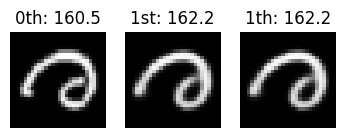

1, 182.07980346679688, 182.07980346679688


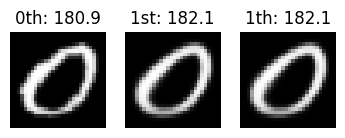

1, 184.6839141845703, 184.6839141845703


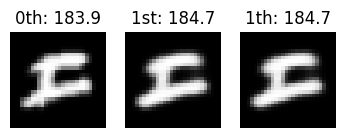

2, 168.4552459716797, 167.55007934570312


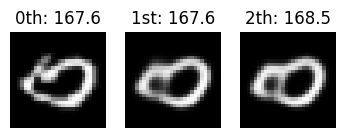

1, 182.01705932617188, 182.01705932617188


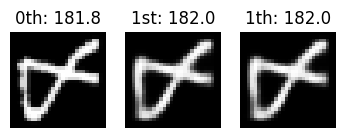

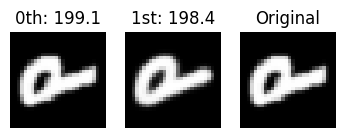

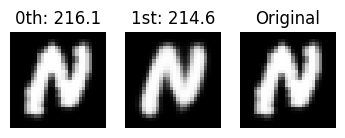

2, 187.67868041992188, 187.26126098632812


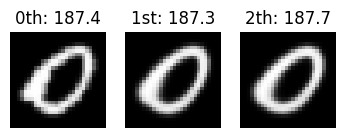

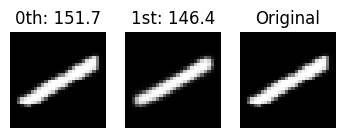

1, 203.4327392578125, 203.4327392578125


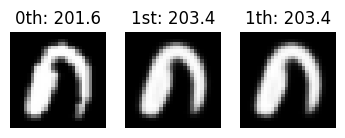

1, 171.0869140625, 171.0869140625


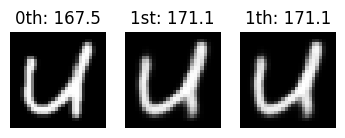

1, 95.62294006347656, 95.62294006347656


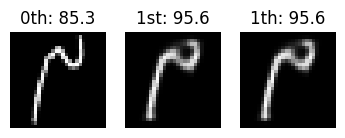

1, 164.75648498535156, 164.75648498535156


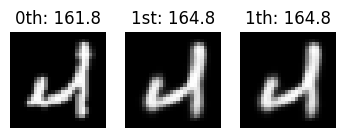

1, 181.23101806640625, 181.23101806640625


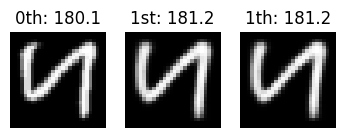

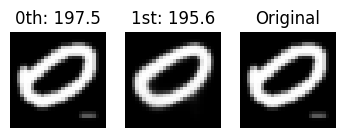

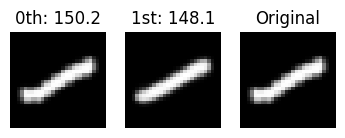

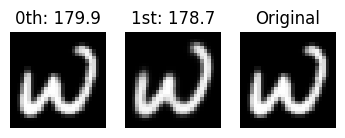

1, 176.44830322265625, 176.44830322265625


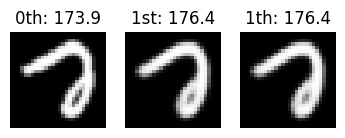

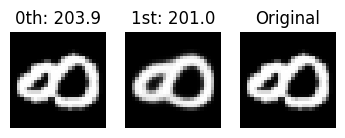

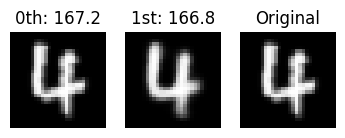

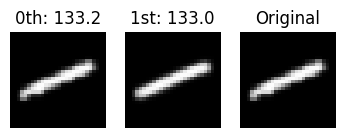

1, 208.67652893066406, 208.67652893066406


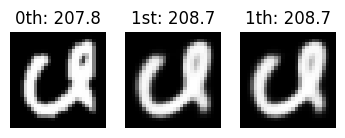

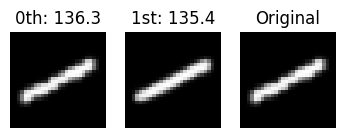

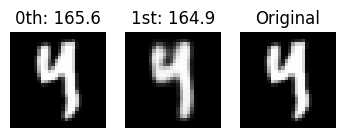

1, 153.08517456054688, 153.08517456054688


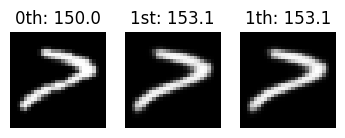

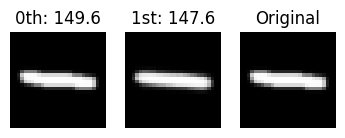

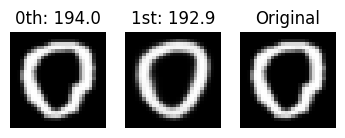

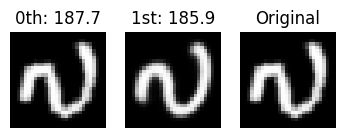

1, 187.8477020263672, 187.8477020263672


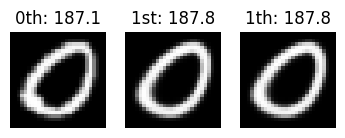

1, 179.98402404785156, 179.98402404785156


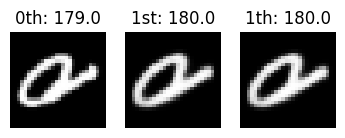

1, 201.06088256835938, 201.06088256835938


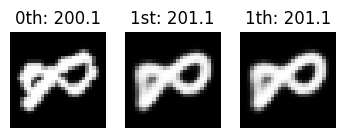

1, 178.39138793945312, 178.39138793945312


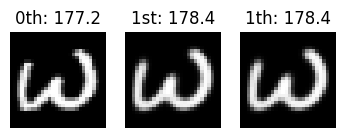

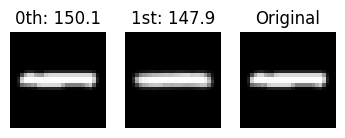

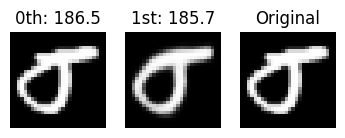

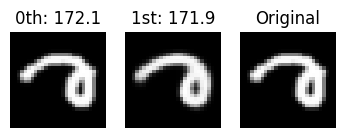

1, 178.12403869628906, 178.12403869628906


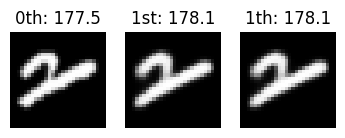

1, 155.51222229003906, 155.51222229003906


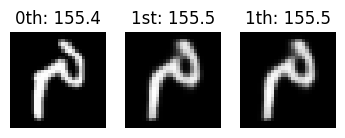

1, 176.27536010742188, 176.27536010742188


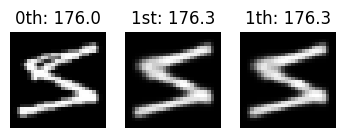

1, 191.1494598388672, 191.1494598388672


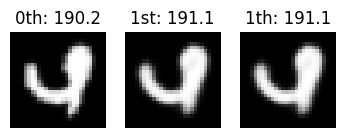

1, 158.4984588623047, 158.4984588623047


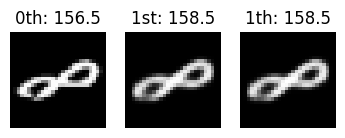

1, 204.40811157226562, 204.40811157226562


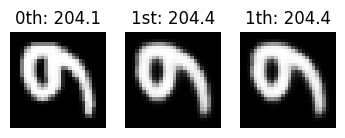

1, 188.84957885742188, 188.84957885742188


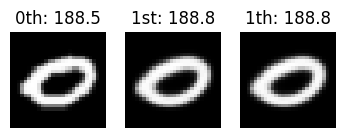

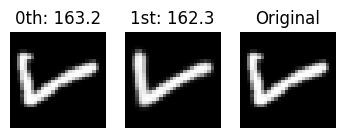

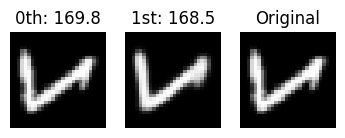

1, 205.22442626953125, 205.22442626953125


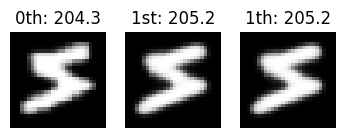

1, 142.34170532226562, 142.34170532226562


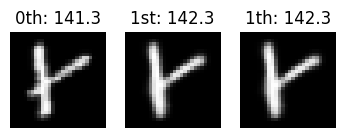

1, 181.68450927734375, 181.68450927734375


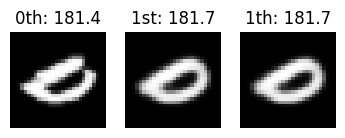

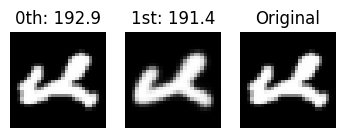

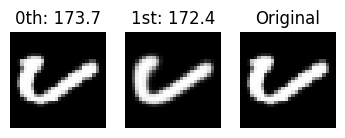

1, 183.90748596191406, 183.90748596191406


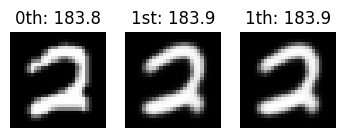

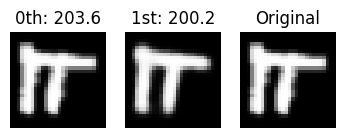

1, 204.26617431640625, 204.26617431640625


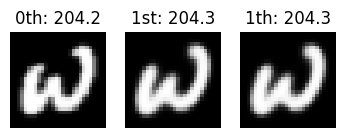

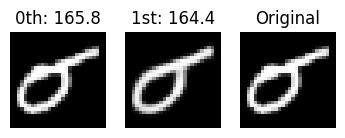

1, 171.81777954101562, 171.81777954101562


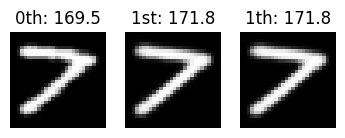

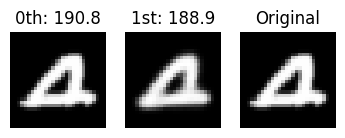

1, 193.8723602294922, 193.8723602294922


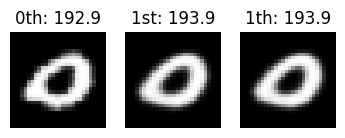

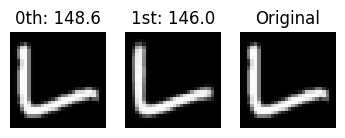

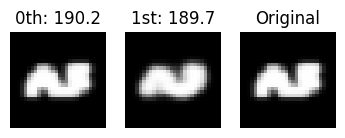

3, 164.67901611328125, 162.93096923828125


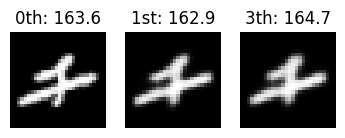

1, 209.364990234375, 209.364990234375


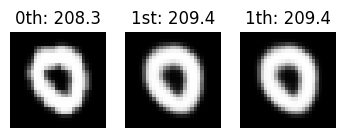

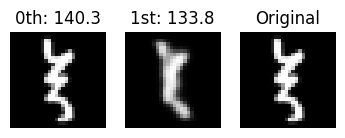

2, 183.03248596191406, 182.3607177734375


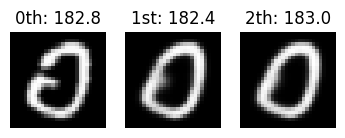

1, 155.02078247070312, 155.02078247070312


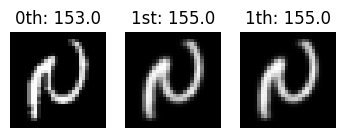

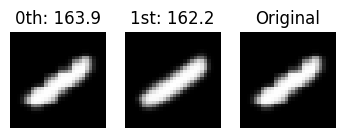

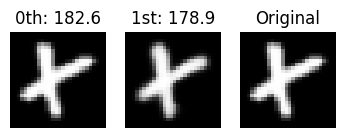

1, 142.2767791748047, 142.2767791748047


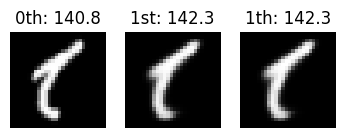

1, 159.6190185546875, 159.6190185546875


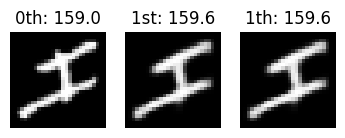

1, 130.585693359375, 130.585693359375


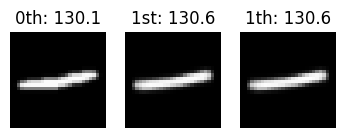

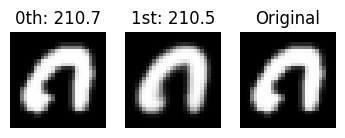

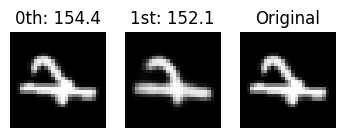

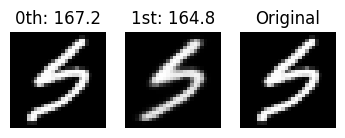

3, 153.50228881835938, 151.65708923339844


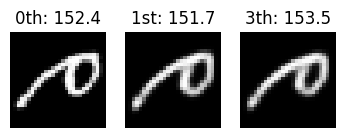

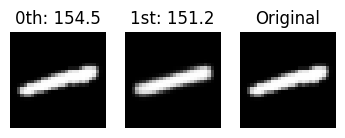

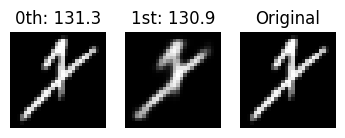

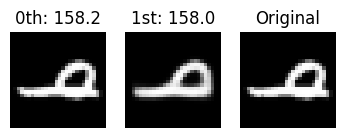

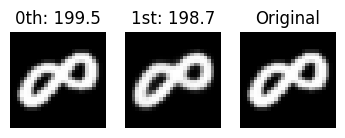

1, 113.36865997314453, 113.36865997314453


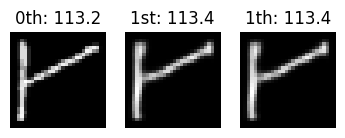

1, 161.49603271484375, 161.49603271484375


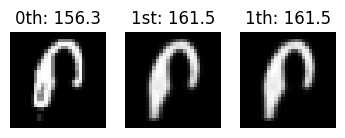

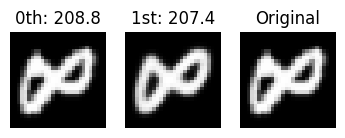

1, 156.24656677246094, 156.24656677246094


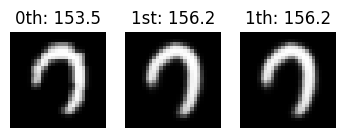

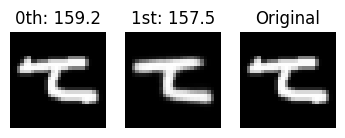

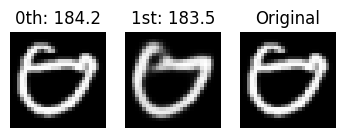

1, 128.25546264648438, 128.25546264648438


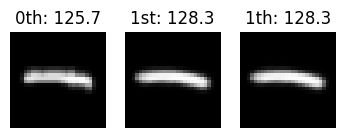

1, 161.5325927734375, 161.5325927734375


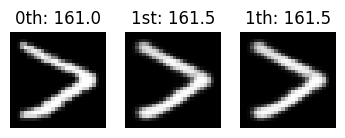

1, 214.5025634765625, 214.5025634765625


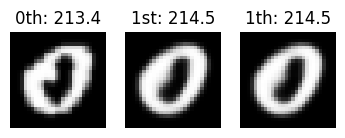

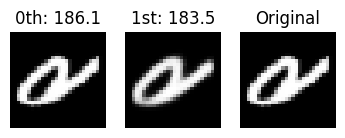

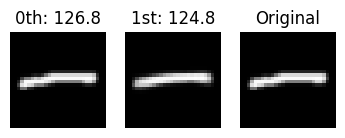

3, 143.11856079101562, 142.5126190185547


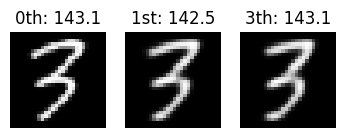

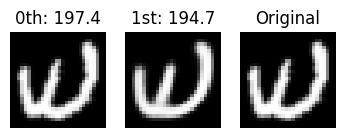

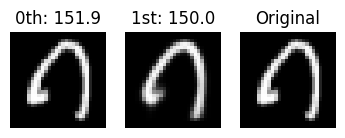

3, 182.70094299316406, 180.12977600097656


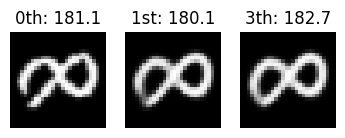

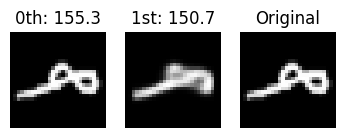

1, 149.15771484375, 149.15771484375


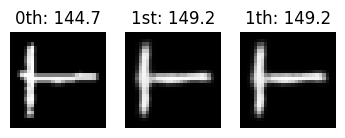

1, 173.01356506347656, 173.01356506347656


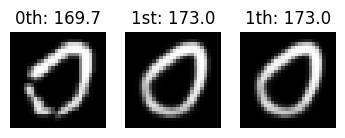

1, 115.25486755371094, 115.25486755371094


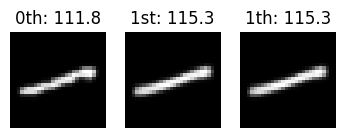

1, 183.748779296875, 183.748779296875


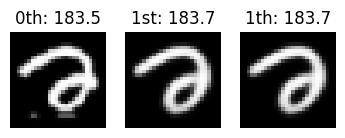

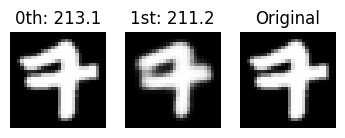

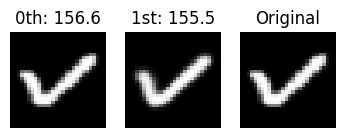

1, 169.73992919921875, 169.73992919921875


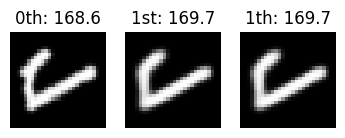

1, 182.37722778320312, 182.37722778320312


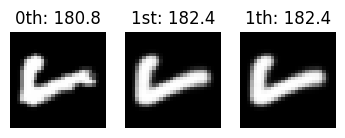

1, 193.56227111816406, 193.56227111816406


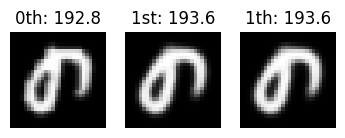

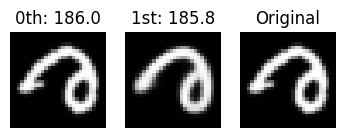

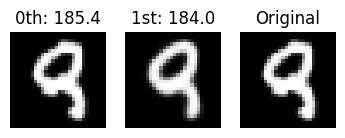

1, 186.76788330078125, 186.76788330078125


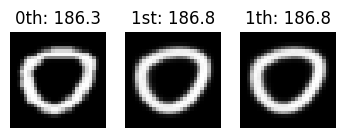

1, 164.685791015625, 164.685791015625


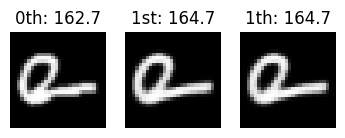

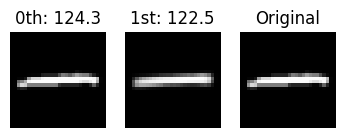

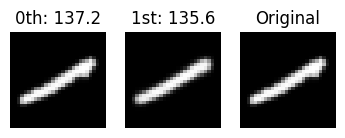

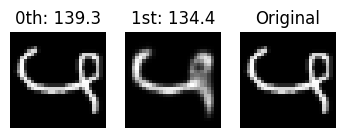

1, 183.85684204101562, 183.85684204101562


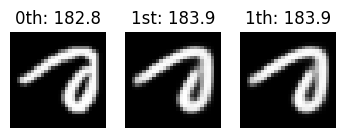

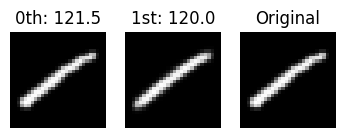

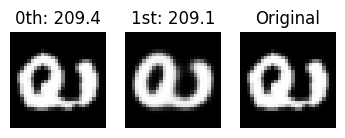

1, 147.44102478027344, 147.44102478027344


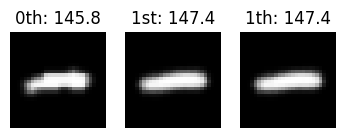

1, 117.57876586914062, 117.57876586914062


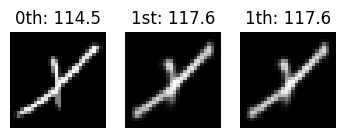

1, 185.91766357421875, 185.91766357421875


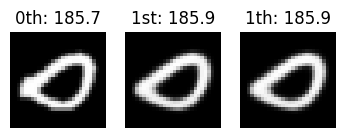

1, 196.05760192871094, 196.05760192871094


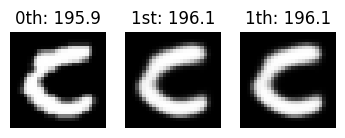

1, 200.51876831054688, 200.51876831054688


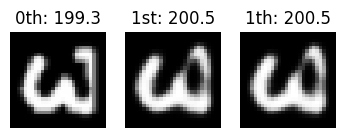

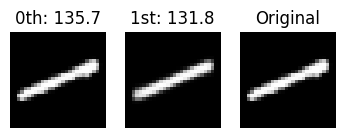

1, 154.08346557617188, 154.08346557617188


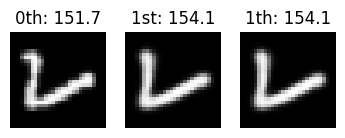

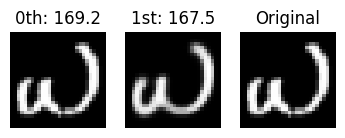

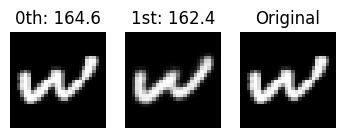

1, 148.13597106933594, 148.13597106933594


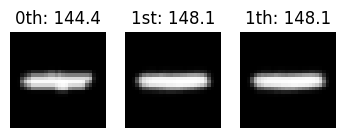

1, 160.96617126464844, 160.96617126464844


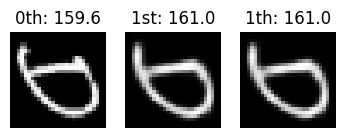

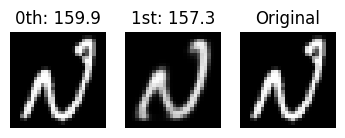

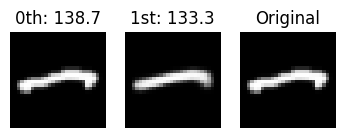

1, 213.42437744140625, 213.42437744140625


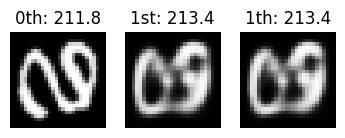

1, 145.56130981445312, 145.56130981445312


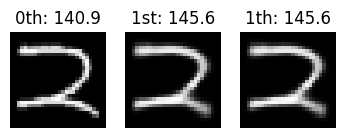

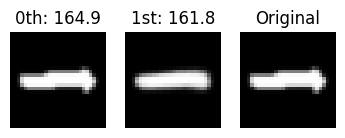

3, 159.82330322265625, 159.38424682617188


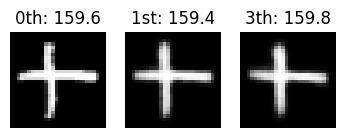

1, 177.06149291992188, 177.06149291992188


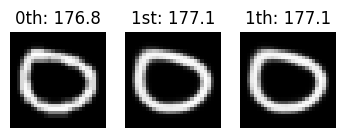

1, 136.38980102539062, 136.38980102539062


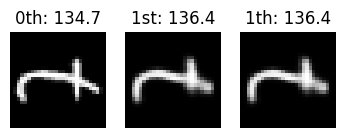

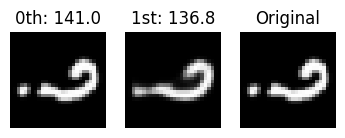

1, 195.369384765625, 195.369384765625


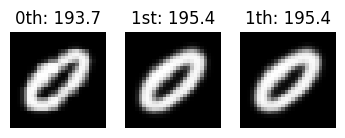

1, 183.79737854003906, 183.79737854003906


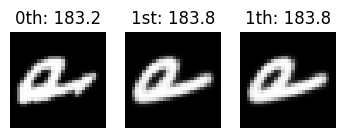

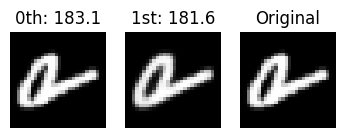

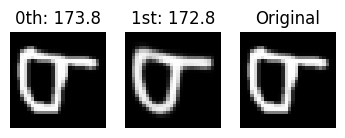

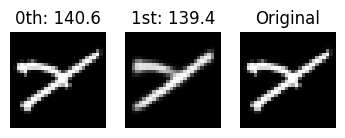

1, 145.72528076171875, 145.72528076171875


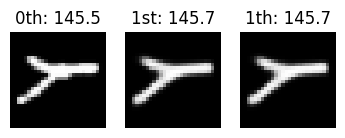

1, 187.042724609375, 187.042724609375


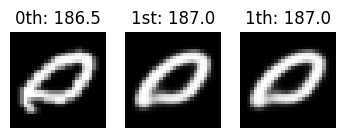

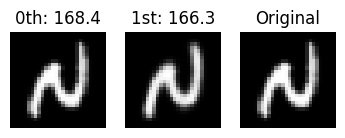

1, 187.18307495117188, 187.18307495117188


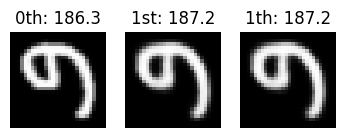

2, 192.9210205078125, 192.61331176757812


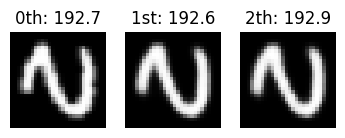

1, 163.60128784179688, 163.60128784179688


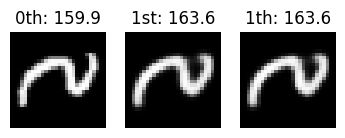

1, 174.28610229492188, 174.28610229492188


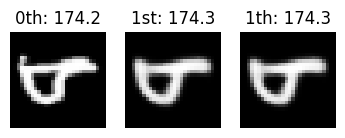

1, 176.20706176757812, 176.20706176757812


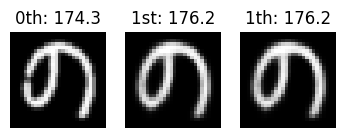

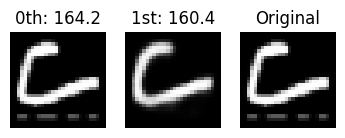

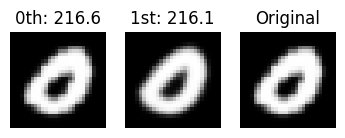

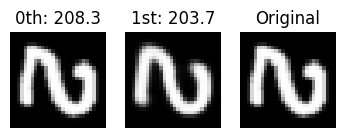

1, 172.59652709960938, 172.59652709960938


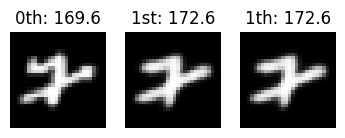

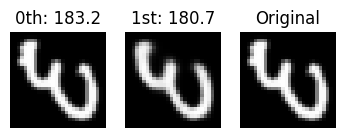

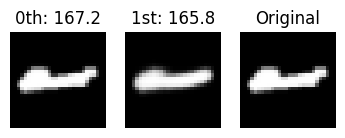

1, 171.26431274414062, 171.26431274414062


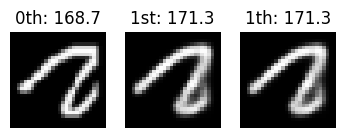

1, 186.6495361328125, 186.6495361328125


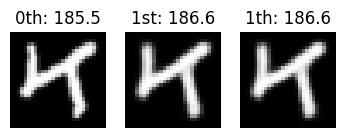

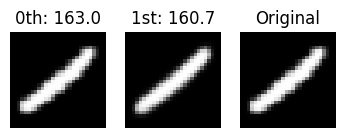

1, 192.7362060546875, 192.7362060546875


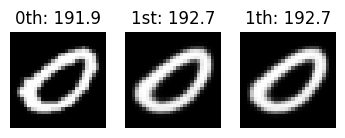

1, 141.09878540039062, 141.09878540039062


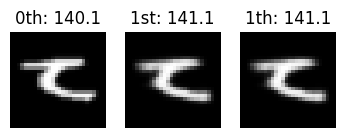

1, 173.93084716796875, 173.93084716796875


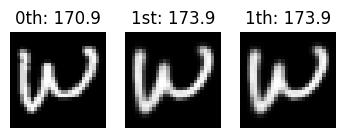

1, 139.25747680664062, 139.25747680664062


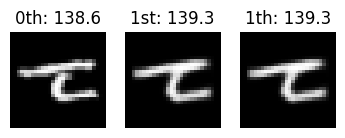

1, 184.37057495117188, 184.37057495117188


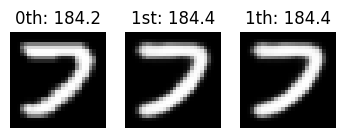

1, 168.9554443359375, 168.9554443359375


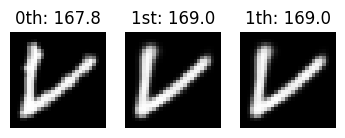

1, 201.4471435546875, 201.4471435546875


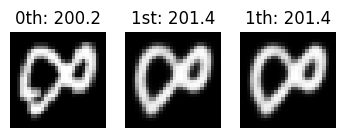

1, 170.6410675048828, 170.6410675048828


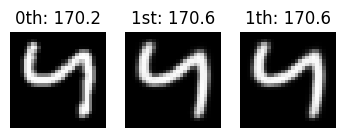

1, 172.9309539794922, 172.9309539794922


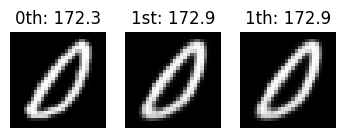

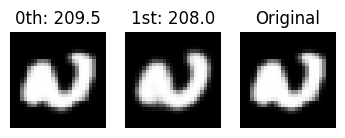

1, 212.55287170410156, 212.55287170410156


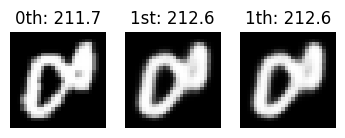

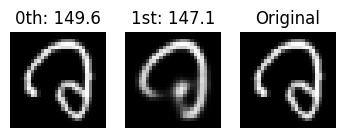

1, 171.44972229003906, 171.44972229003906


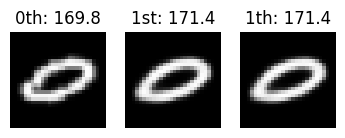

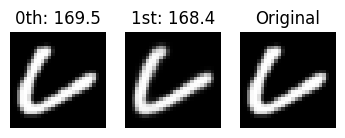

3, 166.7906951904297, 165.7638702392578


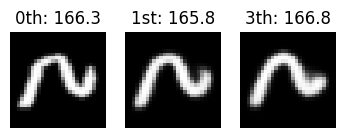

1, 171.54391479492188, 171.54391479492188


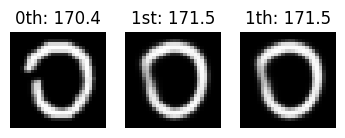

1, 200.154052734375, 200.154052734375


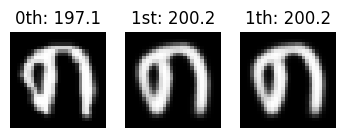

1, 152.14271545410156, 152.14271545410156


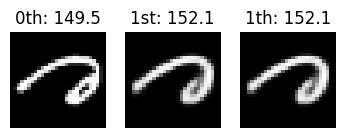

1, 121.61527252197266, 121.61527252197266


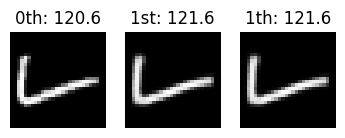

1, 155.60855102539062, 155.60855102539062


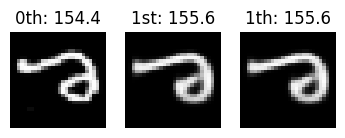

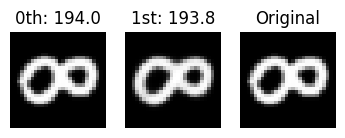

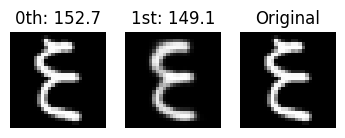

1, 157.0199432373047, 157.0199432373047


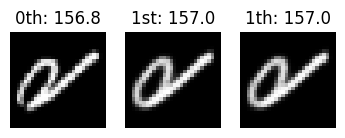

1, 133.15463256835938, 133.15463256835938


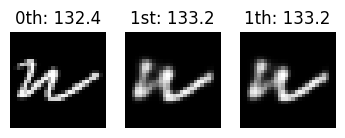

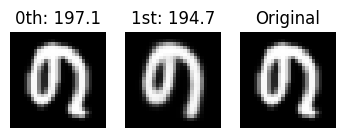

2, 194.19955444335938, 193.1488037109375


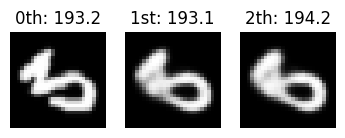

1, 170.1309814453125, 170.1309814453125


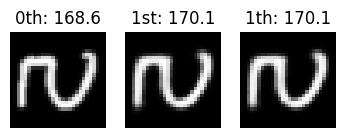

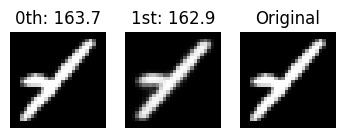

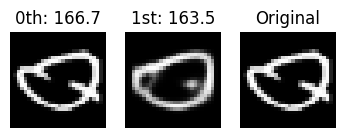

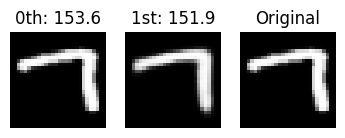

1, 172.65997314453125, 172.65997314453125


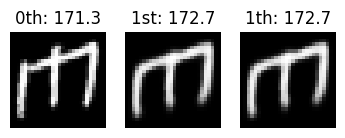

1, 162.87493896484375, 162.87493896484375


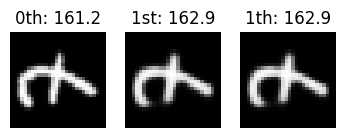

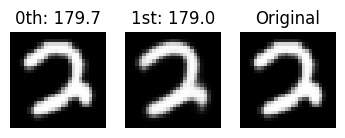

2, 189.6394500732422, 189.57437133789062


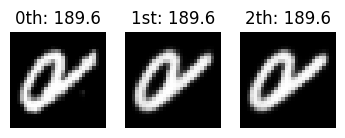

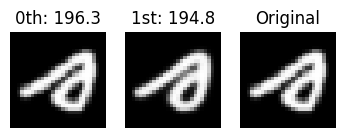

1, 149.92745971679688, 149.92745971679688


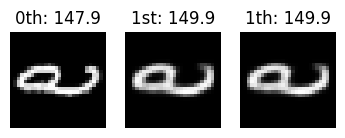

1, 167.7128448486328, 167.7128448486328


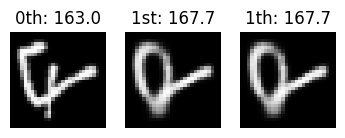

2, 188.291015625, 187.15289306640625


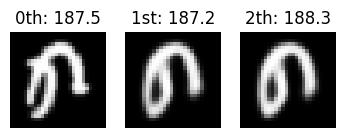

1, 157.77804565429688, 157.77804565429688


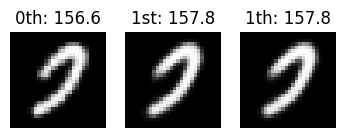

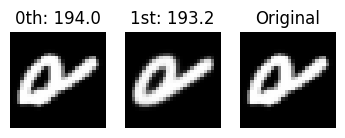

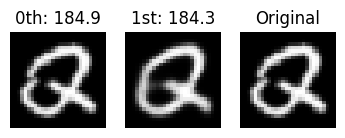

1, 184.82034301757812, 184.82034301757812


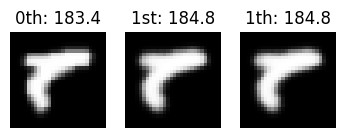

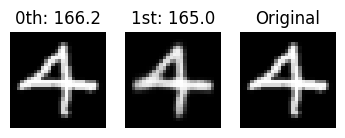

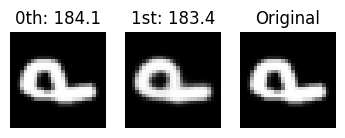

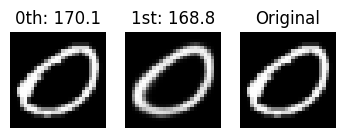

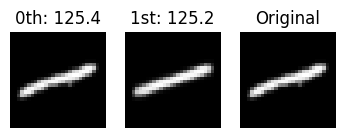

1, 181.9263916015625, 181.9263916015625


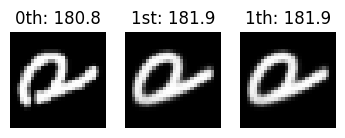

1, 175.10162353515625, 175.10162353515625


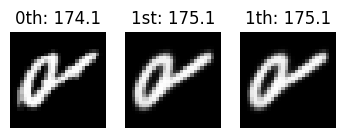

1, 127.08914184570312, 127.08914184570312


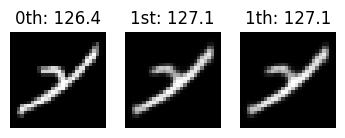

2, 161.84796142578125, 161.1953125


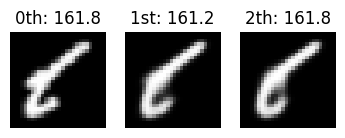

1, 171.38165283203125, 171.38165283203125


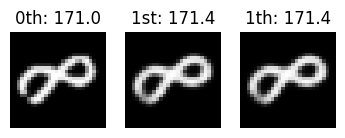

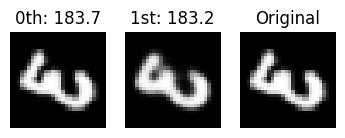

1, 135.88870239257812, 135.88870239257812


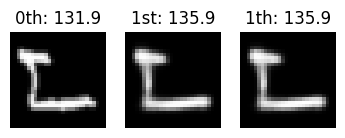

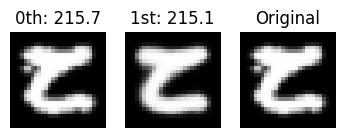

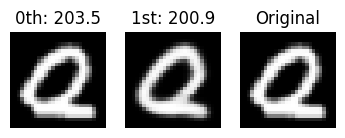

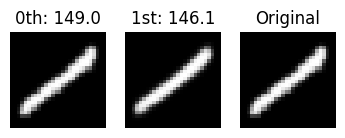

1, 185.12451171875, 185.12451171875


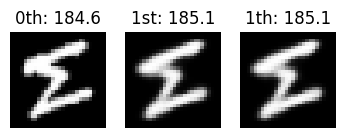

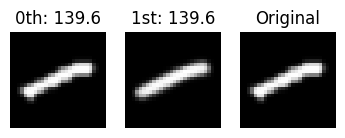

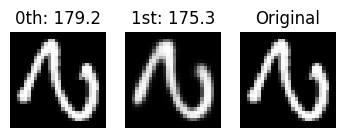

1, 121.88253021240234, 121.88253021240234


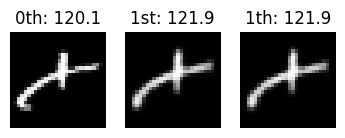

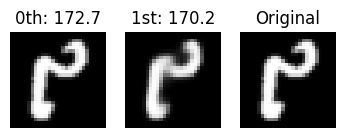

1, 164.5589599609375, 164.5589599609375


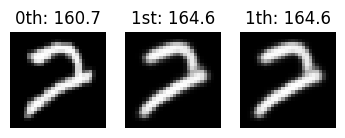

4, 163.76510620117188, 163.53341674804688


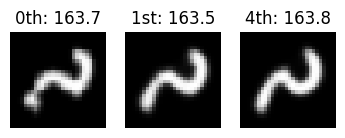

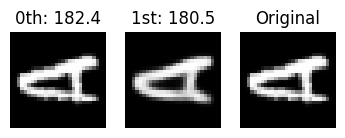

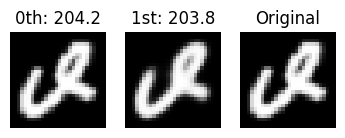

4, 180.67431640625, 179.12008666992188


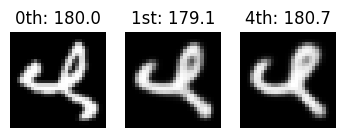

4, 167.504150390625, 165.67523193359375


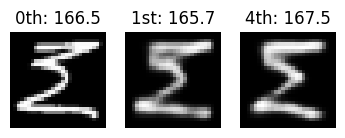

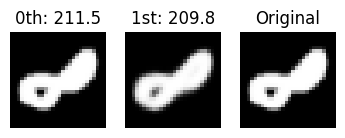

1, 176.36717224121094, 176.36717224121094


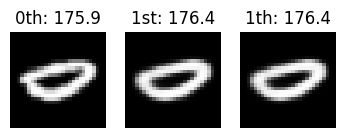

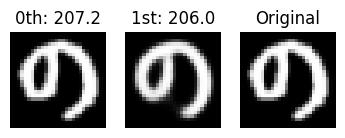

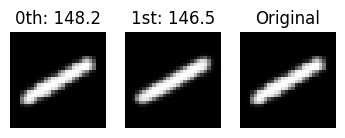

1, 157.77833557128906, 157.77833557128906


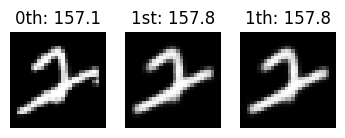

4, 184.55332946777344, 183.24981689453125


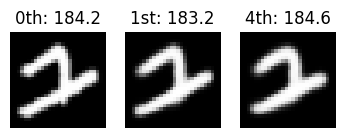

1, 164.1397705078125, 164.1397705078125


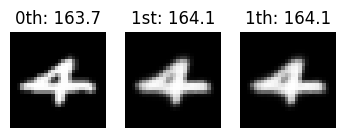

1, 175.2491912841797, 175.2491912841797


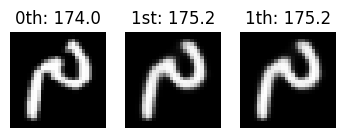

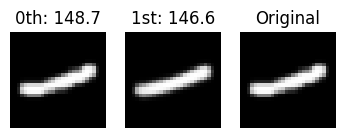

1, 226.34263610839844, 226.34263610839844


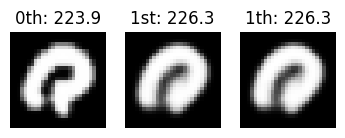

In [10]:
# Testing
data_loader = DataLoader(data_test, batch_size = 250, shuffle = True)
sampling = 5

for data, data_label in data_loader:
    fig, axes = plt.subplots(1, 3, figsize=(6*0.7, 2))
    image = data.to(device)
    values = evaluator(image.reshape(image.size(0),-1))[0]
    image_origin = image[0][0].cpu()
    value_origin = torch.log(values+1e-5).sum().item()
    axes[0].imshow(image_origin, cmap='gray')
    axes[0].set_title(f'0th: {value_origin:.1f}')
    axes[0].axis('off')  # Turn off axis numbers

    recon_x = image
    count = 0
    for i in range(1, sampling):
        recon_x, mean, log_var = model(recon_x, do_reparam = False)
        image = recon_x[0].detach()
        values = evaluator(image.reshape(image.size(0),-1))[0]
        value_image = torch.log(values+1e-5).sum().item()

        if i == 1:
            value = value_image
            axes[1].imshow(image[0].cpu(), cmap='gray')
            axes[1].set_title(f'1st: {value_image:.1f}')
            axes[1].axis('off')  # Turn off axis numbers

        if value_image >= value and value_image > value_origin:
            count += 1
            print(f"{i}, {value_image}, {value}")
            value = value_image
            axes[2].imshow(image[0].cpu(), cmap='gray')
            axes[2].set_title(f'{i}th: {value_image:.1f}')
            axes[2].axis('off')  # Turn off axis numbers
            if count == 1:
                break
    if count == 0:
        axes[2].imshow(image_origin, cmap='gray')
        axes[2].set_title(f'Original')
        axes[2].axis('off')  # Turn off axis numbers
    plt.show()
    plt.close()